In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from numpy import arange, array

from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, PolynomialFeatures
from sklearn.feature_selection import SelectKBest, SelectFromModel
from sklearn.feature_selection import f_regression, mutual_info_regression
from sklearn.compose import ColumnTransformer, make_column_selector

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import KFold, cross_val_score
from sklearn.linear_model import ElasticNet, Lasso, Ridge, LinearRegression
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score

pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 200)

In [2]:
housing = pd.read_csv('data/houseprice_clean.csv')
housing.shape 
# 2580 x 81

housing_newfeat = pd.read_csv('data/houseprice_newfeat.csv')
housing_newfeat.shape
# 2580 x 92

(2580, 92)

In [59]:
housing_newfeat.head()

,GrLivArea,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,Heating,HeatingQC,CentralAir,Electrical,KitchenQual,Functional,FireplaceQu,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition,GarageSize,Remodel_binary,TotalIndoorSF,LotPercent,LivArea_sq,Log_LivArea,Remodel_Neighborhood,Remodel_Year,Remodel_Qual,Remodel_GrLiv,Remodel_TotSF,Remodel_Bath,Neighborhood_Num,SalePrice,Log_SalePrice
0,856,1S_1945older,58.800593,7890,6,6,1939,1950,0.0,238.0,0.0,618.0,856.0,856,0,0,1.0,0.0,1,0,2,1,4,1,1939.0,2.0,399.0,0,0,0,0,166,0,0,3,2010,RL,Pave,None,Reg,Lvl,AllPub,Corner,Gtl,SWISU,Norm,Norm,1Fam,1Story,Gable,CompShg,Wd Sdng,Wd Sdng,None,TA,TA,CBlock,TA,TA,No,Rec,Unf,GasA,TA,Y,SBrkr,TA,Typ,Gd,Detchd,Unf,TA,TA,Y,None,None,None,WD,Normal,large,1,1712.0,0.108492,732736,6.752270,SWISU,1939,6,856,1712.0,1,17,126000,11.744037
1,1049,1S_PUD,42.000000,4235,5,5,1984,1984,149.0,552.0,393.0,104.0,1049.0,1049,0,0,1.0,0.0,2,0,2,1,5,0,1984.0,1.0,266.0,0,105,0,0,0,0,0,2,2009,RL,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,Edwards,Norm,Norm,TwnhsE,1Story,Gable,CompShg,HdBoard,HdBoard,BrkFace,Gd,TA,CBlock,Gd,TA,Mn,GLQ,ALQ,GasA,TA,Y,SBrkr,Gd,Typ,None,Attchd,Fin,TA,TA,Y,None,None,None,WD,Normal,small,0,2098.0,0.247698,1100401,6.955593,NaN,0,0,0,0.0,0,7,139500,11.845820
2,1001,1S_1945older,60.000000,6060,5,9,1930,2007,0.0,737.0,0.0,100.0,837.0,1001,0,0,0.0,0.0,1,0,2,1,5,0,1930.0,1.0,216.0,154,0,42,86,0,0,0,11,2007,C (all),Pave,None,Reg,Lvl,AllPub,Inside,Gtl,IDOTRR,Norm,Norm,1Fam,1Story,Hip,CompShg,MetalSd,MetalSd,None,Gd,TA,BrkTil,TA,TA,No,ALQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,None,Detchd,Unf,TA,Po,N,None,None,None,WD,Normal,small,1,1838.0,0.165182,1002001,6.908755,IDOTRR,1930,5,1001,1838.0,1,5,124900,11.735269
3,1039,2S_1945older,80.000000,8146,4,8,1900,2003,0.0,0.0,0.0,405.0,405.0,717,322,0,0.0,0.0,1,0,2,1,6,0,1940.0,1.0,281.0,0,0,168,0,111,0,0,5,2009,RL,Pave,None,Reg,Lvl,AllPub,Corner,Gtl,OldTown,Norm,Norm,1Fam,2Story,Gable,CompShg,MetalSd,MetalSd,None,Gd,Gd,BrkTil,Fa,TA,No,Unf,Unf,GasA,Gd,Y,SBrkr,TA,Typ,None,Detchd,Unf,TA,TA,N,None,None,None,WD,Normal,small,1,1444.0,0.088019,1079521,6.946014,OldTown,1900,4,1039,1444.0,1,12,114000,11.643954
4,1665,2S_1946newer,70.000000,8400,8,6,2001,2001,0.0,643.0,0.0,167.0,810.0,810,855,0,1.0,0.0,2,1,3,1,6,0,2001.0,2.0,528.0,0,45,0,0,0,0,0,11,2009,RL,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,NWAmes,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,None,Gd,TA,PConc,Gd,TA,No,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,None,Attchd,Fin,TA,TA,Y,None,None,None,WD,Normal,large,0,2475.0,0.096429,2772225,7.417580,NaN,0,0,0,0.0,0,23,227000,12.332705


## Pipeline: Model and Feature Set Comparison

In [3]:
feature_sets = {
    "Original_features": housing.drop(['SalePrice', 'Log_SalePrice'], axis=1),
    "New_features": housing_newfeat.drop(['SalePrice', 'Log_SalePrice'], axis=1)
}

target_sets = {
    "SalePrice": housing['SalePrice'],
    "Log_SalePrice": housing['Log_SalePrice']
}

In [6]:
col_transform = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), make_column_selector(dtype_include=np.number)),
        ("cat", OneHotEncoder(sparse_output = False, handle_unknown = 'ignore'), 
                 make_column_selector(dtype_include=object))], 
        verbose_feature_names_out = False
)

ridge_pipe = Pipeline(
    steps=[
        ("cols", col_transform), 
        ("regression", Ridge())]
)

models = {'Ridge': ridge_pipe
          }

In [7]:
def test(models):
    
    r2_train = []
    r2_test = []
    cross_val = []
    mod_details = []
    
    for m in models:
        for f in feature_sets:
            for t in target_sets:
                X = feature_sets[f]
                y = target_sets[t]
                X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
                models[m].fit(X_train, y_train)
                r2_train.append(models[m].score(X_train, y_train))
                r2_test.append(models[m].score(X_test, y_test))
                cross_val.append((cross_val_score(models[m], X, y, cv=10, scoring="r2")).mean())
                mod_details.append(str(m) + '_' + str(f) + '_' + str(t))
        
    results = pd.DataFrame(
                {'Train R^2': r2_train,
                 'Test R^2': r2_test,
                 'Mean CV Score': cross_val
                }, index = mod_details
            )
    
    return results

test(models)

,Train R^2,Test R^2,Mean CV Score
Ridge_Original_features_SalePrice,0.940076,0.917859,0.912472
Ridge_Original_features_Log_SalePrice,0.948302,0.909429,0.917826
Ridge_New_features_SalePrice,0.942243,0.918913,0.906000
Ridge_New_features_Log_SalePrice,0.953836,0.915062,0.924882


## Ridge Regression

In [9]:
X = housing_newfeat.drop(['SalePrice', 'Log_SalePrice'], axis=1)
y = housing['Log_SalePrice']

In [10]:
X_transformed = col_transform.fit_transform(X)
new_feat_names = col_transform.get_feature_names_out()
X = pd.DataFrame(X_transformed, columns = new_feat_names)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

In [11]:
ridge = Ridge()
ridge.fit(X_train, y_train)

cv = KFold(n_splits=10, shuffle = True, random_state = 0)
scores = cross_val_score(ridge, X_test, y_test, cv=cv, scoring="r2")

print(scores)
print(f"Average R-squared score: {scores.mean()}")

[0.88325034 0.93599902 0.96194056 0.92766706 0.94056602 0.91031531
 0.92969921 0.91248198 0.87246639 0.91968436]
Average R-squared score: 0.9194070263024562


In [14]:
params1 = {"alpha": [0.001, 0.01, 1, 100, 1000, 10000, 100000]} # 100
params2 = {"alpha": arange(1, 1000, 50)} # 51
params3 = {"alpha": arange(0, 100, 1)} # 17

ridge = Ridge()
cv = KFold(n_splits=10, shuffle = True, random_state = 0)
gs = GridSearchCV(ridge, params3, scoring='r2', cv=cv)
gs.fit(X_train, y_train)

scores = cross_val_score(gs.best_estimator_, X, y, cv=cv, scoring="r2")

print(gs.best_params_)
print(scores.mean())

{'alpha': 17}
0.9267794449378848


In [15]:
ridge = Ridge(alpha = 17)
cv = KFold(n_splits=10, shuffle = True, random_state = 0)

ridge.fit(X_train, y_train)

scores = cross_val_score(ridge, X, y, cv=cv, scoring="r2")
scores.mean()

0.9267794449378848

In [30]:
y_true = y
y_pred = ridge.predict(X)

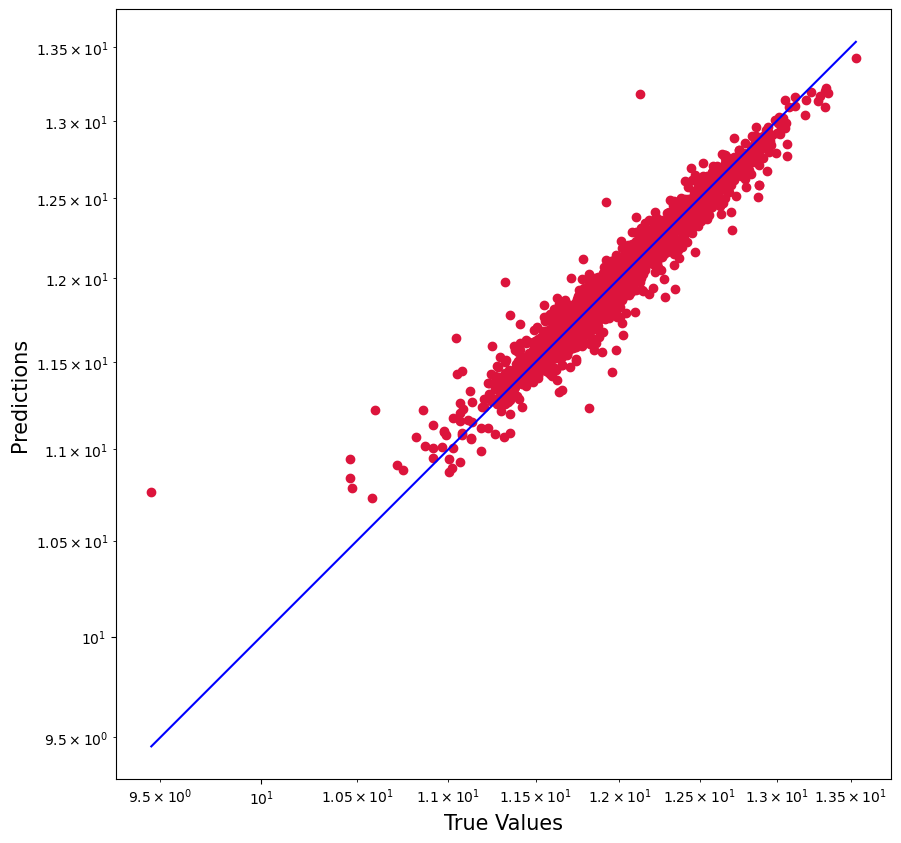

In [31]:
plt.figure(figsize=(10,10))
plt.scatter(y_true, y_pred, c='crimson')
plt.yscale('log')
plt.xscale('log')

p1 = max(max(y_pred), max(y_true))
p2 = min(min(y_pred), min(y_true))
plt.plot([p1, p2], [p1, p2], 'b-')

plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.axis('equal')
plt.show()

In [54]:
# examine homes where predicted value is above actual sale price
housing_newfeat['y_pred'] = ridge.predict(X)
housing_newfeat['error'] = housing_newfeat['Log_SalePrice'] - housing_newfeat['y_pred']

homes_underval = housing_newfeat[housing_newfeat['Log_SalePrice'] < housing_newfeat['y_pred']]

In [55]:
homes_underval.shape
# about half of the observations

(1242, 94)

In [37]:
homes_underval.describe()

,GrLivArea,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,Remodel_binary,TotalIndoorSF,LotPercent,LivArea_sq,Log_LivArea,Neighborhood_Num,Remodel_Qual,Remodel_GrLiv,Remodel_TotSF,Remodel_Bath,SalePrice,Log_SalePrice,y_pred
count,1242.000000,1242.000000,1242.000000,1242.000000,1242.000000,1242.000000,1242.000000,1242.000000,1242.000000,1242.000000,1242.000000,1242.000000,1242.000000,1242.000000,1242.000000,1242.000000,1242.000000,1242.000000,1242.000000,1242.000000,1242.000000,1242.000000,1242.000000,1242.000000,1242.000000,1242.000000,1242.000000,1242.00000,1242.000000,1242.000000,1242.000000,1242.000000,1242.000000,1242.000000,1242.000000,1242.000000,1242.000000,1242.000000,1.242000e+03,1242.000000,1242.000000,1242.000000,1242.000000,1242.000000,1242.000000,1242.000000,1242.000000,1242.000000
mean,1467.342995,72.334133,9938.064412,6.056361,5.649758,1970.538647,1984.148148,95.331723,425.522544,57.392915,534.363124,1017.278583,1129.570853,334.136876,3.635266,0.444444,0.060386,1.545089,0.381643,2.815620,1.041063,6.329308,0.609501,1975.433172,1.727858,455.700483,96.105475,41.36715,20.958937,2.427536,16.896940,1.513688,33.747987,6.144928,2007.814815,0.457327,2484.621578,0.138425,2.364730e+06,7.242620,13.933172,2.678744,678.100644,1106.979871,0.679549,164488.454106,11.940898,12.005790
std,460.223239,54.319086,9633.765618,1.321750,1.198523,29.741359,20.461216,171.242267,420.480907,181.313682,426.084908,426.819976,378.657649,409.350011,35.498519,0.519302,0.244967,0.538580,0.505491,0.804288,0.206474,1.505915,0.664277,25.988886,0.730379,200.140923,132.254727,58.20872,56.370900,24.998114,58.334063,31.369959,227.691845,2.721259,1.293200,0.498376,745.381294,0.071471,1.577044e+06,0.315234,7.592431,3.069805,813.821762,1322.691875,0.826856,62463.761321,0.380996,0.362220
min,334.000000,12.669329,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,1872.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,0.000000,334.000000,0.009082,1.115560e+05,5.811141,1.000000,0.000000,0.000000,0.000000,0.000000,12789.000000,9.456341,10.728770
25%,1119.750000,56.000000,7200.000000,5.000000,5.000000,1953.000000,1966.000000,0.000000,0.000000,0.000000,200.250000,768.000000,861.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,2.000000,1.000000,5.000000,0.000000,1958.000000,1.000000,312.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,2007.000000,0.000000,1960.000000,0.095699,1.253842e+06,7.020860,6.000000,0.000000,0.000000,0.000000,0.000000,124600.000000,11.732863,11.786342
50%,1430.500000,67.520073,9135.000000,6.000000,5.000000,1972.000000,1993.000000,0.000000,356.500000,0.000000,460.000000,970.000000,1053.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,3.000000,1.000000,6.000000,1.000000,1977.000000,2.000000,469.500000,0.000000,21.50000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,0.000000,2443.500000,0.120545,2.046330e+06,7.265779,16.000000,0.000000,0.000000,0.000000,0.000000,154000.000000,11.944708,11.995641
75%,1713.750000,80.000000,11340.750000,7.000000,6.000000,1999.000000,2003.000000,148.750000,719.750000,0.000000,779.500000,1251.250000,1361.500000,703.500000,0.000000,1.000000,0.000000,2.000000,1.000000,3.000000,1.000000,7.000000,1.000000,2000.000000,2.000000,563.500000,166.750000,63.00000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,1.000000,2928.000000,0.156636,2.936939e+06,7.446439,20.000000,6.000000,1391.250000,2232.000000,1.000000,192400

<Axes: >

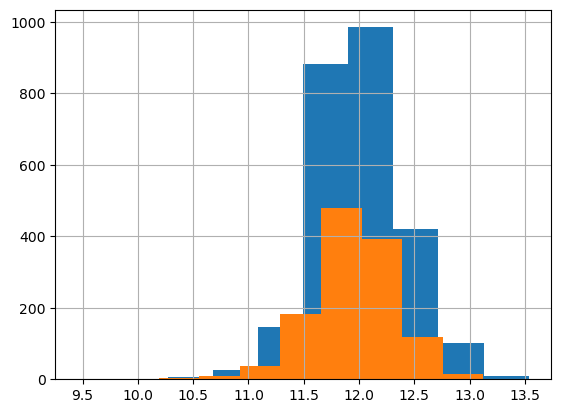

In [48]:
# homes that are undervalued have a similar distribution to homes overall
# more normally distributed
housing_newfeat['Log_SalePrice'].hist()
homes_underval['Log_SalePrice'].hist()

In [60]:
# view undervalued homes with the greatest error
homes_underval.sort_values('error', ascending = True).head(10)

,GrLivArea,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,Heating,HeatingQC,CentralAir,Electrical,KitchenQual,Functional,FireplaceQu,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition,Remodel_binary,GarageSize,TotalIndoorSF,LotPercent,LivArea_sq,Log_LivArea,Neighborhood_Num,Remodel_Qual,Remodel_GrLiv,Remodel_TotSF,Remodel_Bath,SalePrice,Log_SalePrice,y_pred,error
427,832,1S_1945older,68.000000,9656,2,2,1923,1970,0.0,0.0,0.0,678.0,678.0,832,0,0,0.0,0.0,1,0,2,1,5,1,1928.0,2.0,780.0,0,0,0,0,0,0,0,6,2010,RM,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,OldTown,Norm,Norm,1Fam,1Story,Gable,CompShg,AsbShng,AsbShng,None,TA,Fa,BrkTil,Fa,Fa,No,Unf,Unf,GasA,TA,N,SBrkr,TA,Typ,Gd,Detchd,Unf,Fa,Fa,N,None,None,None,WD,Abnorml,1,large,1510.0,0.086164,692224,6.723832,12,2,832,1510.0,1,12789,9.456341,10.761646,-1.305305
309,4676,2S_1946newer,130.000000,40094,10,5,2007,2008,762.0,2260.0,0.0,878.0,3138.0,3138,1538,0,1.0,0.0,3,1,3,1,11,1,2007.0,3.0,884.0,208,406,0,0,0,0,0,10,2007,RL,Pave,None,IR1,Bnk,AllPub,Inside,Gtl,Edwards,PosN,PosN,1Fam,2Story,Hip,CompShg,CemntBd,CmentBd,Stone,Ex,TA,PConc,Ex,TA,Gd,GLQ,Unf,GasA,Ex,Y,SBrkr,Ex,Typ,Gd,BuiltIn,Fin,TA,TA,Y,None,None,None,New,Partial,1,large,7814.0,0.078266,21864976,8.450198,7,10,4676,7814.0,3,184750,12.126759,13.183023,-1.056265
180,1411,1S_1946newer,85.000000,11900,7,5,1977,1977,209.0,822.0,0.0,564.0,1386.0,1411,0,0,0.0,0.0,2,0,3,1,6,1,1977.0,2.0,544.0,192,0,0,0,0,0,0,4,2009,RL,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,NWAmes,Norm,Norm,1Fam,1Story,Hip,CompShg,Plywood,Plywood,BrkFace,TA,Gd,CBlock,TA,TA,No,ALQ,Unf,GasA,TA,Y,SBrkr,TA,Typ,TA,Attchd,Fin,TA,TA,Y,None,None,None,WD,Family,0,large,2797.0,0.118571,1990921,7.252054,23,0,0,0.0,0,82500,11.320554,11.977593,-0.657039
740,1317,2S_1945older,50.000000,8500,4,4,1920,1950,0.0,0.0,0.0,649.0,649.0,649,668,0,0.0,0.0,1,0,3,1,6,0,1920.0,1.0,250.0,0,54,172,0,0,0,0,7,2008,C (all),Pave,Pave,Reg,Lvl,AllPub,Inside,Gtl,IDOTRR,Feedr,Norm,1Fam,2Story,Gambrel,CompShg,BrkFace,BrkFace,None,TA,Fa,BrkTil,TA,TA,No,Unf,Unf,GasA,TA,N,SBrkr,TA,Typ,None,Detchd,Unf,TA,Fa,N,None,MnPrv,None,WD,Normal,1,small,1966.0,0.076353,1734489,7.183112,5,4,1317,1966.0,1,40000,10.596635,11.224761,-0.628126
1533,864,1S_1946newer,60.000000,8281,5,5,1965,1965,0.0,553.0,311.0,0.0,864.0,864,0,0,0.0,0.0,1,0,3,1,5,1,1965.0,1.0,360.0,0,0,236,0,0,0,0,12,2009,RL,Pave,None,IR1,Lvl,AllPub,Inside,Gtl,Sawyer,Norm,Norm,1Fam,1Story,Gable,CompShg,MetalSd,MetalSd,None,TA,TA,CBlock,TA,TA,No,Rec,BLQ,GasA,Gd,Y,SBrkr,TA,Typ,Po,Detchd,Unf,TA,TA,Y,None,GdWo,None,WD,Normal,0,small,1728.0,0.104335,746496,6.761573,1,0,0,0.0,0,62383,11.041048,11.642280,-0.601232
275,2944,2S_1946newer,183.123976,24572,9,3,1977,1977,1050.0,410.0,0.0,584.0,994.0,1599,1345,0,0.0,0.0,2,2,3,1,9,1,1977.0,3.0,864.0,140,70,16,0,0,0,0,6,2008,RL,Pave,None,IR1,Lvl,AllPub,CulDSac,Gtl,Veenker,Norm,Norm,1Fam,2Story,Mansard,CompShg,Wd Sdng,Wd Sdng,BrkFace,Gd,Gd,CBlock,Gd,TA,No,GLQ,Unf,GasA,TA,Y,SBrkr,Gd,Typ,Gd,Attchd,RFn,TA,TA,Y,None,None,None,WD,Family,0,large,3938.0,0.065074,8667136,7.987524,24,0,0,0.0,0,150000,11.918391,12.472610,-0.554219
558,720,1S_1945older,60.000000,7879,4,5,1920,1950,0.0,495.0,0.0,225.0,720.0,720,0,0,0.0,0.0,1,0,2,1,4,0,1920.0,0.0,0.0,0,523,115,0,0,0,0,11,2009,C (all),Pave,None,Reg,Lvl,AllPub,Inside,Gtl,IDOTRR,Norm,Norm,1Fam,1Story,Gable,CompShg,Wd Sdng,Wd Sdng,None,TA,TA,CBlock,TA,TA,No,Rec,Un

In [65]:
# explore top 100 undervalued homes
underval_top = homes_underval.sort_values('error', ascending = True).head(100)
underval_top

,GrLivArea,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,Heating,HeatingQC,CentralAir,Electrical,KitchenQual,Functional,FireplaceQu,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition,Remodel_binary,GarageSize,TotalIndoorSF,LotPercent,LivArea_sq,Log_LivArea,Neighborhood_Num,Remodel_Qual,Remodel_GrLiv,Remodel_TotSF,Remodel_Bath,SalePrice,Log_SalePrice,y_pred,error
427,832,1S_1945older,68.000000,9656,2,2,1923,1970,0.0,0.0,0.0,678.0,678.0,832,0,0,0.0,0.0,1,0,2,1,5,1,1928.0,2.0,780.0,0,0,0,0,0,0,0,6,2010,RM,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,OldTown,Norm,Norm,1Fam,1Story,Gable,CompShg,AsbShng,AsbShng,None,TA,Fa,BrkTil,Fa,Fa,No,Unf,Unf,GasA,TA,N,SBrkr,TA,Typ,Gd,Detchd,Unf,Fa,Fa,N,None,None,None,WD,Abnorml,1,large,1510.0,0.086164,692224,6.723832,12,2,832,1510.0,1,12789,9.456341,10.761646,-1.305305
309,4676,2S_1946newer,130.000000,40094,10,5,2007,2008,762.0,2260.0,0.0,878.0,3138.0,3138,1538,0,1.0,0.0,3,1,3,1,11,1,2007.0,3.0,884.0,208,406,0,0,0,0,0,10,2007,RL,Pave,None,IR1,Bnk,AllPub,Inside,Gtl,Edwards,PosN,PosN,1Fam,2Story,Hip,CompShg,CemntBd,CmentBd,Stone,Ex,TA,PConc,Ex,TA,Gd,GLQ,Unf,GasA,Ex,Y,SBrkr,Ex,Typ,Gd,BuiltIn,Fin,TA,TA,Y,None,None,None,New,Partial,1,large,7814.0,0.078266,21864976,8.450198,7,10,4676,7814.0,3,184750,12.126759,13.183023,-1.056265
180,1411,1S_1946newer,85.000000,11900,7,5,1977,1977,209.0,822.0,0.0,564.0,1386.0,1411,0,0,0.0,0.0,2,0,3,1,6,1,1977.0,2.0,544.0,192,0,0,0,0,0,0,4,2009,RL,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,NWAmes,Norm,Norm,1Fam,1Story,Hip,CompShg,Plywood,Plywood,BrkFace,TA,Gd,CBlock,TA,TA,No,ALQ,Unf,GasA,TA,Y,SBrkr,TA,Typ,TA,Attchd,Fin,TA,TA,Y,None,None,None,WD,Family,0,large,2797.0,0.118571,1990921,7.252054,23,0,0,0.0,0,82500,11.320554,11.977593,-0.657039
740,1317,2S_1945older,50.000000,8500,4,4,1920,1950,0.0,0.0,0.0,649.0,649.0,649,668,0,0.0,0.0,1,0,3,1,6,0,1920.0,1.0,250.0,0,54,172,0,0,0,0,7,2008,C (all),Pave,Pave,Reg,Lvl,AllPub,Inside,Gtl,IDOTRR,Feedr,Norm,1Fam,2Story,Gambrel,CompShg,BrkFace,BrkFace,None,TA,Fa,BrkTil,TA,TA,No,Unf,Unf,GasA,TA,N,SBrkr,TA,Typ,None,Detchd,Unf,TA,Fa,N,None,MnPrv,None,WD,Normal,1,small,1966.0,0.076353,1734489,7.183112,5,4,1317,1966.0,1,40000,10.596635,11.224761,-0.628126
1533,864,1S_1946newer,60.000000,8281,5,5,1965,1965,0.0,553.0,311.0,0.0,864.0,864,0,0,0.0,0.0,1,0,3,1,5,1,1965.0,1.0,360.0,0,0,236,0,0,0,0,12,2009,RL,Pave,None,IR1,Lvl,AllPub,Inside,Gtl,Sawyer,Norm,Norm,1Fam,1Story,Gable,CompShg,MetalSd,MetalSd,None,TA,TA,CBlock,TA,TA,No,Rec,BLQ,GasA,Gd,Y,SBrkr,TA,Typ,Po,Detchd,Unf,TA,TA,Y,None,GdWo,None,WD,Normal,0,small,1728.0,0.104335,746496,6.761573,1,0,0,0.0,0,62383,11.041048,11.642280,-0.601232
275,2944,2S_1946newer,183.123976,24572,9,3,1977,1977,1050.0,410.0,0.0,584.0,994.0,1599,1345,0,0.0,0.0,2,2,3,1,9,1,1977.0,3.0,864.0,140,70,16,0,0,0,0,6,2008,RL,Pave,None,IR1,Lvl,AllPub,CulDSac,Gtl,Veenker,Norm,Norm,1Fam,2Story,Mansard,CompShg,Wd Sdng,Wd Sdng,BrkFace,Gd,Gd,CBlock,Gd,TA,No,GLQ,Unf,GasA,TA,Y,SBrkr,Gd,Typ,Gd,Attchd,RFn,TA,TA,Y,None,None,None,WD,Family,0,large,3938.0,0.065074,8667136,7.987524,24,0,0,0.0,0,150000,11.918391,12.472610,-0.554219
558,720,1S_1945older,60.000000,7879,4,5,1920,1950,0.0,495.0,0.0,225.0,720.0,720,0,0,0.0,0.0,1,0,2,1,4,0,1920.0,0.0,0.0,0,523,115,0,0,0,0,11,2009,C (all),Pave,None,Reg,Lvl,AllPub,Inside,Gtl,IDOTRR,Norm,Norm,1Fam,1Story,Gable,CompShg,Wd Sdng,Wd Sdng,None,TA,TA,CBlock,TA,TA,No,Rec,Un

In [72]:
# look at how feature relationships are different for undervalued homes
housing_newfeat.corr()['SalePrice'].sort_values(ascending = False)

/var/folders/br/94g31g292jj5vykvq71cy53m0000gn/T/ipykernel_52886/620734344.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  housing_newfeat.corr()['SalePrice'].sort_values(ascending = False)


SalePrice           1.000000
Log_SalePrice       0.950051
y_pred              0.928560
TotalIndoorSF       0.819266
OverallQual         0.790501
GrLivArea           0.719981
LivArea_sq          0.699848
Log_LivArea         0.699264
TotalBsmtSF         0.652494
1stFlrSF            0.642613
GarageCars          0.638785
GarageArea          0.634976
Neighborhood_Num    0.627622
YearBuilt           0.544370
FullBath            0.534982
GarageYrBlt         0.532087
YearRemodAdd        0.514309
MasVnrArea          0.498432
TotRmsAbvGrd        0.490219
Fireplaces          0.488184
BsmtFinSF1          0.461070
WoodDeckSF          0.333232
OpenPorchSF         0.306540
BsmtFullBath        0.290755
HalfBath            0.285875
LotArea             0.274443
2ndFlrSF            0.263144
error               0.237390
LotFrontage         0.208847
Remodel_TotSF       0.193966
Remodel_GrLiv       0.175859
BsmtUnfSF           0.168060
BedroomAbvGr        0.151806
Remodel_Bath        0.130500
Remodel_Qual  

In [73]:
underval_top.corr()['SalePrice'].sort_values(ascending = False)
# features that have higher correlation with price:
# GarageCars

/var/folders/br/94g31g292jj5vykvq71cy53m0000gn/T/ipykernel_52886/2218614092.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  underval_top.corr()['SalePrice'].sort_values(ascending = False)


SalePrice           1.000000
y_pred              0.932231
Log_SalePrice       0.931845
OverallQual         0.781950
TotalIndoorSF       0.735742
Log_LivArea         0.721212
GarageCars          0.699019
1stFlrSF            0.688473
GrLivArea           0.686252
GarageArea          0.630438
Fireplaces          0.622229
TotalBsmtSF         0.615444
YearBuilt           0.611139
YearRemodAdd        0.584684
Neighborhood_Num    0.583470
GarageYrBlt         0.580907
BsmtFinSF1          0.578012
WoodDeckSF          0.550923
LivArea_sq          0.542872
FullBath            0.526494
MasVnrArea          0.495189
TotRmsAbvGrd        0.472768
BsmtFullBath        0.402954
HalfBath            0.383535
OverallCond         0.327628
3SsnPorch           0.324606
LotFrontage         0.308275
LotArea             0.288927
error               0.243551
2ndFlrSF            0.231108
LotPercent          0.213123
BedroomAbvGr        0.179286
BsmtFinSF2          0.162224
Remodel_GrLiv       0.149243
Remodel_TotSF 

<Axes: >

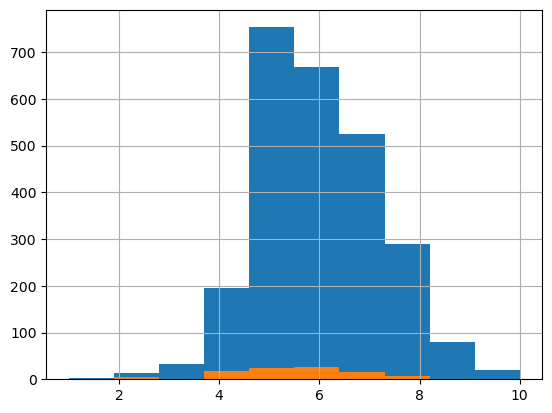

In [68]:
# similar distributions in size
housing_newfeat['OverallQual'].hist()
underval_top['OverallQual'].hist()

In [23]:
coefs_ridge = pd.DataFrame(ridge.coef_, index = X_train.columns, columns = ['coef'])
coefs_ridge.sort_values('coef', ascending = False)

,coef
Log_LivArea,0.070404
GrLivArea,0.062437
OverallQual,0.058134
Neighborhood_Crawfor,0.052804
SaleCondition_Normal,0.050650
...,...
Functional_Maj2,-0.043530
Condition2_PosN,-0.049981
MSZoning_C (all),-0.057785
LivArea_sq,-0.062280


In [29]:
coefs_ridge_absv = abs(coefs_ridge)
coefs_ridge_absv.sort_values('coef', ascending = False).head(20)

,coef
Log_LivArea,0.070404
SaleCondition_Abnorml,0.067692
GrLivArea,0.062437
LivArea_sq,0.062280
OverallQual,0.058134
MSZoning_C (all),0.057785
Neighborhood_Crawfor,0.052804
SaleCondition_Normal,0.050650
OverallCond,0.050469
Condition2_PosN,0.049981


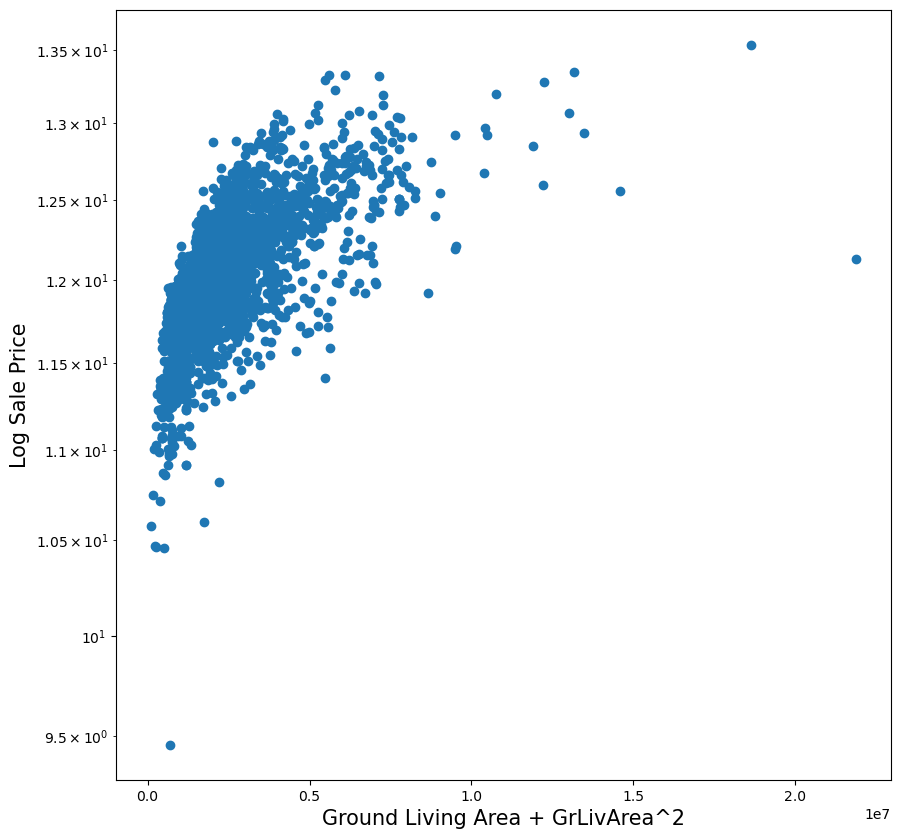

In [28]:
plt.figure(figsize=(10,10))
#plt.scatter(y_true, y_pred, c='crimson')
plt.yscale('log')
#plt.xscale()

plt.scatter(housing_newfeat['GrLivArea'] + housing_newfeat['LivArea_sq'], y)
plt.plot(housing_newfeat['GrLivArea'] + housing_newfeat['LivArea_sq'], y)

plt.xlabel('Ground Living Area + GrLivArea^2', fontsize=15)
plt.ylabel('Log Sale Price', fontsize=15)
plt.show()